In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
import numpy as np
import math
import scipy
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, confusion_matrix, classification_report,roc_curve, auc
from matplotlib.font_manager import FontProperties
from sklearn import linear_model
from sklearn.externals import joblib
plt.rcParams['font.sans-serif'] = ['Simhei']

In [28]:
def load_data():
    
    path = "./数据v13_733_new.csv"
    with open("./预测生死重要指标.txt", 'r', encoding='utf-8') as f_status:
        status_name = f_status.readlines()
    with open("./预测ICU重要指标.txt", 'r', encoding='utf-8') as f_icu:
        icu_name = f_icu.readlines()
    with open("./预测无症状重要指标.txt", 'r', encoding='utf-8') as f_symptom:
        symptom_name = f_symptom.readlines()
    with open("./预测无症状使用特征.txt", 'r', encoding='utf-8') as f_selected:
        selected_name = f_selected.readlines()
    with open("./预测ICU_new_roc10.txt", 'r', encoding='utf-8') as f_woblood:
        woblood_name = f_woblood.readlines()
    with open("./无症状roc10.txt", 'r', encoding='utf-8') as f_symptom_roc10:
        symptom_roc10_name = f_symptom_roc10.readlines()
    with open("./生死roc10.txt", 'r', encoding='utf-8') as f_status_roc10:
        status_roc10_name = f_status_roc10.readlines()
    with open("./预测ICU_new_roc10.txt", 'r', encoding='utf-8') as f_icu_roc10:
        icu_roc10_name = f_icu_roc10.readlines()
    
    for i in range(len(status_name)):
        status_name[i] = status_name[i].strip()
    for i in range(len(icu_name)):
        icu_name[i] = icu_name[i].strip()
    for i in range(len(symptom_name)):
        symptom_name[i] = symptom_name[i].strip()
    for i in range(len(selected_name)):
        selected_name[i] = selected_name[i].strip()
    for i in range(len(woblood_name)):
        woblood_name[i] = woblood_name[i].strip()
    
    for i in range(len(symptom_roc10_name)):
        symptom_roc10_name[i] = symptom_roc10_name[i].strip()
    for i in range(len(status_roc10_name)):
        status_roc10_name[i] = status_roc10_name[i].strip()
    for i in range(len(icu_roc10_name)):
        icu_roc10_name[i] = icu_roc10_name[i].strip()
    
    # print(woblood_name[0:16])
    
    
    csv = pd.read_csv(path)
    feature = csv.iloc[:, 1:92].values
    label = csv.loc[:, ['是否ICU']].values.ravel()
    status = csv.loc[:, status_name].values
    icu = csv.loc[:, icu_name].values
    
    symptom  = csv.loc[:, symptom_name].values
    selected = csv.loc[:, selected_name].values
    woblood = csv.loc[:, woblood_name].values
    
    symptom_roc10  = csv.loc[:, symptom_roc10_name].values
    icu_roc10  = csv.loc[:, icu_roc10_name].values
    status_roc10  = csv.loc[:, status_roc10_name].values
    
    return feature, label, np.array(csv.columns.tolist()[1:92]), \
           status, icu, symptom, selected, woblood, \
           status_roc10, icu_roc10,  symptom_roc10,\
           status_name, icu_name, symptom_name, selected_name, woblood_name, \
           status_roc10_name, icu_roc10_name, symptom_roc10_name
    

# feature, label, columns = load_data()
feature, label, columns, \
status, icu, symptom, selected, woblood, \
status_roc10, icu_roc10, symptom_roc10, \
status_name, icu_name, symptom_name, selected_name, woblood_name, \
status_roc10_name, icu_roc10_name, symptom_roc10_name = load_data()
print(columns)

['年龄' '磷酸肌酸激酶_mean' '磷酸肌酸激酶_var' '乳酸脱氢酶_mean' '乳酸脱氢酶_var' '腺苷脱氨酶_mean'
 '腺苷脱氨酶_var' '总蛋白_mean' '总蛋白_var' '白蛋白_mean' '白蛋白_var' '谷丙转氨酶_mean'
 '谷丙转氨酶_var' '碱性磷酸酶_mean' '碱性磷酸酶_var' '血红蛋白浓度_mean' '血红蛋白浓度_var'
 '红细胞数_mean' '红细胞数_var' '白细胞数_mean' '白细胞数_var' '淋巴细胞绝对值_mean'
 '淋巴细胞绝对值_var' '淋巴细胞百分比_mean' '淋巴细胞百分比_var' '单核细胞绝对值_mean' '单核细胞绝对值_var'
 '单核细胞百分比_mean' '单核细胞百分比_var' '高敏肌钙蛋白I_mean' '高敏肌钙蛋白I_var' '肌红蛋白_mean'
 '肌红蛋白_var' '超敏C反应蛋白_mean' '超敏C反应蛋白_var' '免疫球蛋白IgG_mean' '免疫球蛋白IgG_var'
 '免疫球蛋白IgM_mean' '免疫球蛋白IgM_var' '谷草转氨酶_mean' '谷草转氨酶_var' '降钙素原_mean'
 '降钙素原_var' '总胆固醇_mean' '总胆固醇_var' 'D-二聚体_mean' 'D-二聚体_var' '尿胆元_mean'
 '尿胆元_var' '直接胆红素_mean' '直接胆红素_var' '肌酸激酶同工酶_mean' '肌酸激酶同工酶_var' '体温_mean'
 '体温_var' 'P_mean' 'P_var' 'R_mean' 'R_var' 'BP_High_mean' 'BP_High_var'
 'BP_Low_mean' 'BP_Low_var' 'HR_mean' 'HR_var' '血氧饱和度_mean' '血氧饱和度_var'
 '疾病数目' '肺炎衣原体IgM抗体' '腺病毒IgM抗体' '柯萨奇病毒B组IgM抗体' 'Q热立克次体IgM抗体' '副流感病毒IgM抗体'
 '甲型流感病毒IgM抗体' '乙型流感病毒IgM抗体' '嗜肺军团菌IgM抗体' '肺炎支原体IgM抗体' '呼吸道合胞病毒IgM抗体'
 '人类免疫缺陷病毒抗原及抗

In [29]:
def pre_processing(feature, label, status, icu, symptom, selected, woblood, status_roc10, icu_roc10, symptom_roc10):
    
    # fill blank value
    filler = SimpleImputer(missing_values=np.nan, strategy="median")
    feature = filler.fit_transform(feature)
    
    status = filler.fit_transform(status)
    icu = filler.fit_transform(icu)
    symptom = filler.fit_transform(symptom)
    
    selected = filler.fit_transform(selected)
    woblood = filler.fit_transform(woblood)
    
    status_roc10 = filler.fit_transform(status_roc10)
    icu_roc10 = filler.fit_transform(icu_roc10)
    symptom_roc10 = filler.fit_transform(symptom_roc10)
    
    # scale
    # scalar = StandardScaler().fit(feature[:, 0:67])
    # print(scalar.mean_) 
    # label = make_column_transformer((OrdinalEncoder(), [0]), remainder="passthrough").fit_transform(label)

    feature[:, 0:68] = MinMaxScaler().fit_transform(feature[:, 0:68])
    
    status[:, 0:66] = MinMaxScaler().fit_transform(status[:, 0:66])
    icu[:, 0:52] = MinMaxScaler().fit_transform(icu[:, 0:52])
    symptom[:, 0:22] = MinMaxScaler().fit_transform(symptom[:, 0:22])
    
    selected[:, 0:66] = MinMaxScaler().fit_transform(selected[:, 0:66])

    
    status_roc10[:, 0:10] = MinMaxScaler().fit_transform(status_roc10[:, 0:10])
    icu_roc10[:, 0:10] = MinMaxScaler().fit_transform(icu_roc10[:, 0:10])
    symptom_roc10[:, 0:10] = MinMaxScaler().fit_transform(symptom_roc10[:, 0:10])
    woblood[:, 0:10] = MinMaxScaler().fit_transform(woblood[:, 0:10])

    # return feature, label.ravel()
    return feature, label.ravel(), status, icu, symptom, selected, woblood, \
            status_roc10, icu_roc10, symptom_roc10

feature, label, status, icu, symptom, selected, woblood, \
status_roc10, icu_roc10, symptom_roc10 = \
    pre_processing(feature, label, status, icu, symptom, selected, woblood, status_roc10, icu_roc10, symptom_roc10)
# feature, label = pre_processing(feature, label)

In [4]:
def evaluate(y_true, y_pred):

    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

    SEN = TP/(TP+FN)
    SPE = TN/(TN+FP)
    ACC = (TP + TN) / (TP+TN+FP+FN)
    PRE = TP/(TP+FP)
    AUC = roc_auc_score(y_true, y_pred)
    CM = confusion_matrix(y_true, y_pred)
    CM_PCT = np.array([[TN/(TN+FP), FP/(TN+FP)],
                       [FN/(FN+TP), TP/(FN+TP)]])

    # print(SEN, SPE, ACC, PRE, AUC)
    # print(CM)
    return np.array([SEN, SPE, ACC, AUC]), CM


In [10]:
def evaluate2(y_true, y_pred):

    # print(len(y_true))
    # print(len(y_pred))
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    SEN = TP/(TP+FN)
    SPE = TN/(TN+FP)
    ACC = (TP + TN) / (TP+TN+FP+FN)
    AUC = roc_auc_score(y_true, y_pred)
    # print("TPR: ", TPR)
    # print("FPR: ", FPR)
    # print("SEN: ", SEN)
    # print("SPE: ", SPE)
    # print("ACC: ", ACC)
    # print("AUC: ", AUC)
    return SEN, SPE, ACC, AUC
    # return TPR, FPR, AUC


In [54]:
def split_group():
    sss = StratifiedShuffleSplit(n_splits=1, test_size=147,
                                 random_state=12)
    sps = sss.split(status, label>0)
    for sp in sps:
        train_ids, val_ids = sp

    train_positive_ids = np.array([])
    for id in train_ids:
        if label[id] != 0:
            train_positive_ids = np.append(train_positive_ids, id)
    
    print(len(train_positive_ids))
    
    train_negative_ids = np.setdiff1d(train_ids, train_positive_ids)
    np.random.shuffle(train_negative_ids)
    print(train_positive_ids.shape)
    print(train_negative_ids.shape)
    
    split_groups = np.array_split(train_negative_ids, 22)
    
    # print(split_groups[0].shape)
    
    for i in range(len(split_groups)):
        split_groups[i] = np.concatenate((split_groups[i], train_positive_ids)).astype(np.int)
    
    return split_groups, val_ids

groups, val_ids = split_group()

26
(26,)
(560,)


In [38]:
def random_forest():

    train_pred = []
    train_label = []

    for i in range(len(groups)):
        
        # cls = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1, bootstrap=False)
        # cls = SVC(kernel='linear',C=10000)
        # cls = SVC(kernel='rbf', gamma='auto', C=1000)
        cls = SVC(kernel='poly', C=5000, gamma='auto', degree=2)

        cls.fit(icu_roc10[groups[i], :], label[groups[i]])

        train_pred = train_pred + cls.predict(icu_roc10[groups[i], :]).tolist()
        train_label = train_label + label[groups[i]].tolist()

        roc_pred = cls.predict(icu_roc10)

        pred = cls.predict(icu_roc10[val_ids, :])

        if i == 0:
            final_res = pred
            final_roc_pred = roc_pred
            # feature_ipt = np.expand_dims(cls.feature_importances_, axis=0)
        else:
            final_res = final_res + pred
            final_roc_pred = final_roc_pred + roc_pred
            # importance = cls.feature_importances_
            # feature_ipt = np.concatenate((feature_ipt, np.expand_dims(importance, axis=0)), axis=0)

    train_score, train_cm = evaluate(train_label, train_pred)

    print("-----train-----")
    print(train_score)
    print(train_cm)

    final_res = (final_res > (len(groups) // 2)).astype(float)
    score, cm = evaluate(label[val_ids], final_res)

    # num = 预测要进 实际没进 死了
    top = (final_res == 1) & (label[val_ids] == 0)
    extra_info_id = np.nonzero(top)
    raw_data = pd.read_csv("./数据v13_733_new.csv")
    extra_info_status = raw_data.loc[:, ['生死状态']].values.ravel()[val_ids]
    extra_info_status = extra_info_status[extra_info_id]
    num = np.sum(extra_info_status)

    # num2 = 预测要进  实际进了   死了
    num2_bool = (final_res == 1) & (label[val_ids] == 1)
    num2_id = np.nonzero(num2_bool)
    extra_info_status2 = raw_data.loc[:, ['生死状态']].values.ravel()[val_ids]
    extra_info_status2 = extra_info_status2[num2_id]
    num2 = np.sum(extra_info_status2)

    # total = 所有死亡
    total = np.sum(raw_data.loc[:, ['生死状态']].values.ravel()[val_ids])
    rate = num/(total - num2 + 1e-6)
    print("number is: " + str(num))
    print("total is: " + str(total))
    print("death rate is: " + str(rate))

    final_roc_pred = (final_roc_pred > (len(groups) // 2)).astype(float)
    TPR, FPR, ACC, AUC = evaluate2(label, final_roc_pred)
    print("TPR: " + str(TPR))
    print("FPR: " + str(FPR))
    print("ACC: " + str(ACC))
    print("AUC: " + str(AUC))

    print("-----test-----")
    print(score)
    print(cm)
    return score, cm, # feature_ipt.mean(axis=0)

score, cm,  = random_forest()

# importance = sorted(zip(status_roc10_name, feature_importance), key=lambda feature: feature[1], reverse=True)


-----train-----
[0.90384615 0.91071429 0.90724382 0.90728022]
[[510  50]
 [ 55 517]]
number is: 0
total is: 3
death rate is: 0.0
TPR: 0.9090909090909091
FPR: 0.8571428571428571
ACC: 0.859481582537517
AUC: 0.8831168831168832
-----test-----
[0.85714286 0.90714286 0.9047619  0.88214286]
[[127  13]
 [  1   6]]


In [57]:
def SVM():

    train_pred = []
    train_label = []
    for i in range(len(groups)):
        
        # cls = SVC(kernel='linear',C=1000)
        # cls = SVC(kernel='rbf', gamma='auto', C=5000)
        cls = SVC(kernel='poly', C=70000, gamma='auto', degree=2)
        
        cls.fit(woblood[groups[i], :], label[groups[i]])

        joblib.dump(cls, "./模型/预测是否要进ICU/预测是否模型%s.pkl" % str(i))

        train_pred = train_pred + cls.predict(woblood[groups[i], :]).tolist()
        train_label = train_label + label[groups[i]].tolist()

        pred = cls.predict(woblood[val_ids, :])
        
        if i == 0:
            final_res = pred
        else:
            final_res = final_res + pred

    train_score, train_cm = evaluate(train_label, train_pred)
    print("-----train-----")
    print(train_score)
    print(train_cm)

    final_res = (final_res > (len(groups) // 2)).astype(int)
    score, cm = evaluate(label[val_ids], final_res)
    print("-----test-----")
    print(score)
    print(cm)

    return score, cm

score, cm = SVM()

# importance = sorted(zip(symptom_name, feature_importance), key=lambda feature: feature[1], reverse=True)

-----train-----
[0.93531469 0.96785714 0.95141343 0.95158591]
[[542  18]
 [ 37 535]]
-----test-----
[0.85714286 0.87857143 0.87755102 0.86785714]
[[123  17]
 [  1   6]]


In [29]:
def xgboost():

    train_pred = []
    train_label = []
    for i in range(len(groups)):
        
        cls = XGBClassifier(max_depth=7, learning_rate=0.1)
    
        cls.fit(icu_roc10[groups[i], :], label[groups[i]])

        train_pred = train_pred + cls.predict(icu_roc10[groups[i], :]).tolist()
        train_label = train_label + label[groups[i]].tolist()

        pred = cls.predict(icu_roc10[val_ids, :])
        
        if i == 0:
            final_res = pred
        else:
            final_res = final_res + pred

    train_score, train_cm = evaluate(train_label, train_pred)
    print("-----train-----")
    print(train_score)
    print(train_cm)

    final_res = (final_res > (len(groups) // 2)).astype(float)



    score, cm = evaluate(label[val_ids], final_res)

    print("-----test-----")
    print(score)
    print(cm)
    return score, cm


score, cm = xgboost()

-----train-----
[0.95993031 0.96695652 0.96344648 0.96344342]
[[556  19]
 [ 23 551]]
-----test-----
[1.         0.88111888 0.88435374 0.94055944]
[[126  17]
 [  0   4]]


乳酸脱氢酶_mean
104
白蛋白_mean
146
淋巴细胞绝对值_mean
147
淋巴细胞百分比_mean
147
高敏肌钙蛋白I_mean
47
高敏肌钙蛋白I_var
47
肌红蛋白_mean
48
肌红蛋白_var
48
D-二聚体_mean
141
血氧饱和度_mean
37
血氧饱和度_mean < 82.0 1.0 0.9999999714285723 0.9999999714285794
高敏肌钙蛋白I_var > 19.36 0.9999990000010001 1.0 0.9999990000010108
肌红蛋白_var > 146.41 0.9999990000010001 1.0 0.9999990000010107
白蛋白_mean < 33.2 1.0 0.9784172591480773 0.995375121968378
高敏肌钙蛋白I_mean > 25.7 0.9999990000010001 0.9782608700378072 0.9782598917779264
D-二聚体_mean > 0.97 0.9999998571428775 0.8731343293049677 0.9728143601632993
肌红蛋白_mean > 79.7 0.9999990000010001 0.9574468094160253 0.9574458519701841
乳酸脱氢酶_mean > 428.0 0.799999840000032 1.0 0.9313129457443499
淋巴细胞绝对值_mean < 0.73 0.5714286326530524 0.9857142786734695 0.8005102268622413
淋巴细胞百分比_mean < 8.67 0.714285755102035 0.9928571357653062 0.7780612506377509


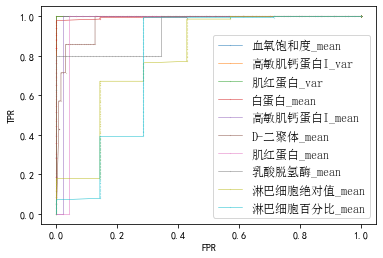

In [188]:
def draw_roc_curve_status():
    font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)
    final = []


    path = "./数据v13_733_new.csv"
    csv = pd.read_csv(path)
    feature = csv.iloc[:, 1:76].values[val_ids]
    label = csv.loc[:, ['是否ICU']].values.ravel()[val_ids]
    columns = np.array(csv.columns.tolist()[1:76])

    # with open("./sel_roc10.txt", 'r', encoding='utf-8') as f_woblood:
    #     woblood_name = f_woblood.readlines()
    # for i in range(len(woblood_name)):
    #     woblood_name[i] = woblood_name[i].strip()

    for i in range(75):
        if columns[i] not in icu_roc10_name:
            continue
        x = feature[:, i]
        # y = make_column_transformer((OrdinalEncoder(), [0]), remainder="passthrough").fit_transform(label).ravel()
        y = label.ravel()
        ids = np.array([], dtype=int)
        for index, item in enumerate(x):
            # print(index, item)
            if not np.isnan(item):
                ids = np.append(ids, index)
        print(columns[i])
        print(len(ids))
        # if len(ids) == 0 or len(ids) <= 17:
        #     continue
        x = x[ids]
        y = y[ids]
        info = np.array(sorted(zip(x, y), key=lambda sample: sample[0], reverse=False))

        x = info[:, 0]
        y = info[:, 1]
        # print(np.sum(y==1))
        # return info
        tprs = [1]
        fprs = [1]
        aucs = [0.5]
        thresholds = [-1]
        for j in range(len(x)):
            threshold = x[j]
            true = y.astype(int)
            pred = (x >= threshold).astype(int)
            cm = confusion_matrix(true, pred, labels=[0, 1])
            auc_item = roc_auc_score(true, pred)
            # print(cm.shape)
            # print(cm)
            TN, FP, FN, TP = cm.flatten()
            tpr = TP / (TP + FN + 1e-6)
            fpr = FP / (TN + FP + 1e-6)
            tprs.append(tpr)
            fprs.append(fpr)
            aucs.append(auc_item)
            thresholds.append(threshold)
        tprs.append(0)
        fprs.append(0)
        aucs.append(0.5)
        thresholds.append(-1)
        auc_score = auc(fprs, tprs)
        # print(tprs)
        # print(fprs)
        # print(auc_score)
        final.append([fprs, tprs, auc_score, columns[i], thresholds, aucs])
    final = sorted(final, key=lambda sample: abs(sample[2] - 0.5), reverse=True)
    # return final
    for i in range(10):

        if final[i][2] < 0.5:
            target = final[i][5].index(min(final[i][5]))
            best_sen = final[i][1][target]
            best_spe = 1 - final[i][0][target]
            best_threshold = final[i][4][target]
            print(final[i][3], "<", best_threshold, 1 - best_sen, 1 - best_spe, max(final[i][2], 1-final[i][2]))
        else:
            target = final[i][5].index(max(final[i][5]))
            best_sen = final[i][1][target]
            best_spe = 1 - final[i][0][target]
            best_threshold = final[i][4][target]
            print(final[i][3], ">", best_threshold, best_sen, best_spe, max(final[i][2], 1-final[i][2]))


        if final[i][2] < 0.5:
            plt.plot(final[i][1], final[i][0], 
                 marker='o', label=str(final[i][3]), linewidth=0.5, markersize=0.1
                 )
        else:
            plt.plot(final[i][0], final[i][1], 
                     marker='o', label=str(final[i][3]), linewidth=0.5, markersize=0.1
                     )
        plt.legend(prop=font_set)
        plt.xlabel("FPR")
        plt.ylabel("TPR")
    # plt.plot(0.101671, 1.0, marker='o',
    #          label="ROC10", linewidth=0.5, markersize=0.5)
    # plt.legend(prop=font_set)
    plt.savefig("./预测new.jpg", dpi=300)
    plt.show()
    return final

final = draw_roc_curve_status()

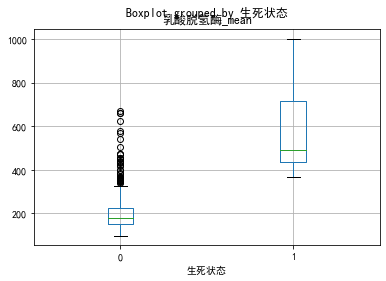

In [28]:
def draw_boxplot():
    font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)
    data = pd.read_csv("./数据v13_736.csv")
    fig = data.boxplot(column='乳酸脱氢酶_mean', by='生死状态')

    # plt.show(fig)
    fig.figure.savefig("./test.svg", dpi=300)
    
    return data
raw_data = draw_boxplot()

# for i in range(20):
#     print(final[i][3])

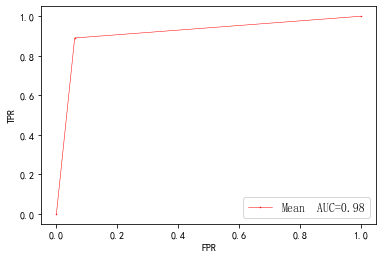

In [9]:
def draw_roc_curve_icu():
    font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)
    # 生死
    status_rf = [
            [[0, 0.0839, 1], [0, 1.0, 1], 0.9580, "All feature on Test Set"],
            [[0, 0.0641, 1], [0, 1.0, 1], 0.9680, "All feature on Full Set"],
            [[0, 0.0909, 1], [0, 1.0, 1], 0.9545, "ROC10 on Test Set"],
            [[0, 0.0738, 1], [0, 1.0, 1], 0.9353, "ROC10 on Full Set"],
    ]
    status_svm1 = [
            [[0, 0.0979, 1], [0, 1.0, 1], 0.9510, "All feature on Test Set"],
            [[0, 0.0794, 1], [0, 1.0, 1], 0.9603, "All feature on Full Set"],
            [[0, 0.1049, 1], [0, 1.0, 1], 0.9476, "ROC10 on Test Set"],
            [[0, 0.0891, 1], [0, 0.94, 1], 0.9277, "ROC10 on Full Set"],
    ]
    status_svm2 = [
            [[0, 0.1119, 1], [0, 1.0, 1], 0.9441, "All feature on Test Set"],
            [[0, 0.0794, 1], [0, 1.0, 1], 0.9603, "All feature on Full Set"],
            [[0, 0.1119, 1], [0, 1.0, 1], 0.9441, "ROC10 on Test Set"],
            [[0, 0.0836, 1], [0, 1.0, 1], 0.9304, "ROC10 on Full Set"],
    ]
    status_svm3 = [
            [[0, 0.1119, 1], [0, 1.0, 1], 0.9441, "All feature on Test Set"],
            [[0, 0.0749, 1], [0, 1.0, 1], 0.9603, "All feature on Full Set"],
            [[0, 0.1119, 1], [0, 1.0, 1], 0.9441, "ROC10 on Test Set"],
            [[0, 0.085, 1], [0, 0.94, 1], 0.9297, "ROC10 on Full Set"],
    ]

    # 判断ICU
    icu1_rf = [
            [[0, 0.0567, 1], [0, 1.0, 1], 0.9716, "All feature on Test Set"],
            [[0, 0.0664, 1], [0, 1.0, 1], 0.9668, "All feature on Full Set"],
            [[0, 0.0709, 1], [0, 1.0, 1], 0.9645, "ROC10 on Test Set"],
            [[0, 0.0777, 1], [0, 1.0, 1], 0.9612, "ROC10 on Full Set"],
    ]
    icu1_svm1 = [
            [[0, 0.0993, 1], [0, 0.83, 1], 0.8670, "All feature on Test Set"],
            [[0, 0.120, 1], [0, 0.9643, 1], 0.9221, "All feature on Full Set"],
            [[0, 0.1348, 1], [0, 1.0, 1], 0.9326, "ROC10 on Test Set"],
            [[0, 0.1031, 1], [0, 1.0, 1], 0.9484, "ROC10 on Full Set"],
    ]
    icu1_svm2 = [
            [[0, 0.1631, 1], [0, 0.83, 1], 0.8351, "All feature on Test Set"],
            [[0, 0.1144, 1], [0, 0.9286, 1], 0.9071, "All feature on Full Set"],
            [[0, 0.1418, 1], [0, 1.0, 1], 0.9291, "ROC10 on Test Set"],
            [[0, 0.1102, 1], [0, 1.0, 1], 0.9449, "ROC10 on Full Set"],
    ]
    icu1_svm3 = [
            [[0, 0.1631, 1], [0, 1.0, 1], 0.9184, "All feature on Test Set"],
            [[0, 0.1285, 1], [0, 0.9643, 1], 0.9179, "All feature on Full Set"],
            [[0, 0.1277, 1], [0, 1.0, 1], 0.9362, "ROC10 on Test Set"],
            [[0, 0.1017, 1], [0, 0.9286, 1], 0.9134, "ROC10 on Full Set"],
    ]

    # 预测ICU
    icu2_rf = [
            [[0, 0.1901, 1], [0, 1.0, 1], 0.9049, "All feature on Test Set"],
            [[0, 0.1554, 1], [0, 1.0, 1], 0.9223, "All feature on Full Set"],
            [[0, 0.2394, 1], [0, 1.0, 1], 0.8803, "ROC10 on Test Set"],
            [[0, 0.2302, 1], [0, 1.0, 1], 0.8849, "ROC10 on Full Set"],
    ]
    icu2_svm1 = [
            [[0, 0.2183, 1], [0, 0.6, 1], 0.6908, "All feature on Test Set"],
            [[0, 0.1850, 1], [0, 0.92, 1], 0.8675, "All feature on Full Set"],
            [[0, 0.1761, 1], [0, 1.0, 1], 0.912, "ROC10 on Test Set"],
            [[0, 0.1554, 1], [0, 0.92, 1], 0.8823, "ROC10 on Full Set"],
    ]
    icu2_svm2 = [
            [[0, 0.2112, 1], [0, 0.6, 1], 0.6944, "All feature on Test Set"],
            [[0, 0.1582, 1], [0, 0.92, 1], 0.8809, "All feature on Full Set"],
            [[0, 0.1901, 1], [0, 1.0, 1], 0.9049, "ROC10 on Test Set"],
            [[0, 0.1667, 1], [0, 0.92, 1], 0.8767, "ROC10 on Full Set"],
    ]
    icu2_svm3 = [
            [[0, 0.2324, 1], [0, 0.6, 1], 0.6838, "All feature on Test Set"],
            [[0, 0.1836, 1], [0, 0.92, 1], 0.8682, "All feature on Full Set"],
            [[0, 0.1761, 1], [0, 1.0, 1], 0.9119, "ROC10 on Test Set"],
            [[0, 0.1511, 1], [0, 0.92, 1], 0.8844, "ROC10 on Full Set"],
    ]

    # 新预测ICU

    icu_new = [
            [[0, 0.2386, 1], [0, 0.7143, 1], 0.7429, "All feature on Test Set"],
            [[0, 0.1857, 1], [0, 0.9394, 1], 0.8768, "All feature on Whole Set"],
            [[0, 0.1714, 1], [0, 0.8571, 1], 0.8429, "ROC10 on Test Set"],
            [[0, 0.1314, 1], [0, 0.8788, 1], 0.8737, "ROC10 on Whole Set"],
    ]

    # 3fold cv
    three_fold_cv = [
        [[0, 0., 1], [0, 1, 1], 1, "Fold1  AUC=1"],
        [[0, 0., 1], [0, 0.67, 1], 0.83, "Fold2  AUC=0.83"],
        [[0, 0.17, 1], [0, 1, 1], 0.92, "Fold3  AUC=0.92"],
        [[0, 0.06, 1], [0, 0.89, 1], 0.92, "Mean   AUC=0.92"]
    ]

    # 3fold cv one point

    three_fold_cv_2 = [
        [[0, 0.06, 1], [0, 0.89, 1], 0.98, "Mean  AUC=0.98"]
    ]

    target = three_fold_cv_2
    for i in range(1):

        if target[i][2] < 0.5:
            plt.plot(target[i][1], target[i][0],
                 marker='o', color='r', label=str(target[i][3]), linewidth=0.5, markersize=0.5
                 )
        else:
            plt.plot(target[i][0], target[i][1],
                     marker='o', color='r', label=str(target[i][3]), linewidth=0.5, markersize=0.5
                     )
        plt.legend(prop=font_set)
        plt.xlabel("FPR")
        plt.ylabel("TPR")

    plt.savefig("./3fold.svg", dpi=300)
    plt.show()

    return
draw_roc_curve_icu()

In [ ]:
def draw_roc_curve_symptom():
    return

In [61]:
def lasso():

    path = "./数据v14_14.csv"
    csv = pd.read_csv(path)
    feature = csv.iloc[:, 1:92].values
    label = csv.loc[:, ['ICU']].values.ravel()
    columns = np.array(csv.columns.tolist()[1:92])

    with open("./新ICU回归.txt", 'r', encoding='utf-8') as f_newicu:
        newicu_name = f_newicu.readlines()
    for i in range(len(newicu_name)):
        newicu_name[i] = newicu_name[i].strip()

    newicu = csv.loc[:, newicu_name].values

    filler = SimpleImputer(missing_values=np.nan, strategy="median")
    newicu = filler.fit_transform(newicu)
    newicu[:, 0:10] = MinMaxScaler().fit_transform(newicu[:, 0:10])
    feature = filler.fit_transform(feature)
    feature[:, 0:68] = MinMaxScaler().fit_transform(feature[:, 0:68])

    cv_reg = linear_model.Lasso(alpha=0.001)
    # cv_reg = linear_model.LinearRegression()

    i = 0
    j = 0
    subdata = newicu[:, j].reshape(-1,1)

    scores = cross_validate(cv_reg, newicu, label,
                            return_train_score=True, cv=3, return_estimator=True ,scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
    # est_res = []
    weight = np.array([])

    pred = []
    for est in scores['estimator']:
        joblib.dump(est, "./模型/预测ICU天数/ICU天数回归模型%s.pkl" % str(i))
        if i == 0:
            weight = np.expand_dims([item for item in est.coef_], axis=0)
            # print([abs(item) for item in est.coef_])
            pred = est.predict(newicu)
            # print(pred)
            i+=1
        else:
            # print([abs(item) for item in est.coef_])
            weight = np.concatenate((weight, np.expand_dims([item for item in est.coef_], axis=0)), axis=0)
            pred += est.predict(newicu)
            # print(pred)
            i+=1


    weight = weight.mean(axis=0)
    pred = pred/3

    res = sorted(zip(weight, newicu_name), key=lambda name: name[0], reverse=True)
    for i in range(10):
        print(res[i])

    print(pred)
    print(label)

    # ae_array = list(map(abs, pred - label))
    tnmae = scores['test_neg_mean_absolute_error']
    print(newicu_name[j],  abs(tnmae.mean()))


    return scores

lasso = lasso()

(4.264050166962895, '淋巴细胞绝对值_mean')
(3.0362463692557515, '心脏病')
(2.4767852525624714, '红细胞数_mean')
(0.34047617495416177, '总胆固醇_mean')
(-0.08086791229484659, '年龄')
(-0.3667811301927226, '腺病毒IgM抗体')
(-0.46389952988146904, '超敏C反应蛋白_mean')
(-0.6714421878687911, '高敏肌钙蛋白I_var')
(-0.8659853956916024, '总胆固醇_var')
(-1.8209640546204635, 'Q热立克次体IgM抗体')
[1.1196279  6.92989623 1.84627125 1.781049   2.00261985 2.5666964
 3.43836333 5.84725967 6.65815475 1.9632359  4.4205384  7.5394129
 1.0097866  2.18711793]
[1 7 2 2 2 2 4 6 7 2 4 7 1 2]
年龄 0.7232059270307415


[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]


E:\Development\Anaconda\envs\Pytorch\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03697623451861551, tolerance: 0.012575000000000001
  positive)
E:\Development\Anaconda\envs\Pytorch\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.038421998744991484, tolerance: 0.013175000000000001
  positive)
E:\Development\Anaconda\envs\Pytorch\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03796872318211784, tolerance: 0.012823529411764708
  positive)
E:\Development\Anaconda\envs\Pytorch\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge

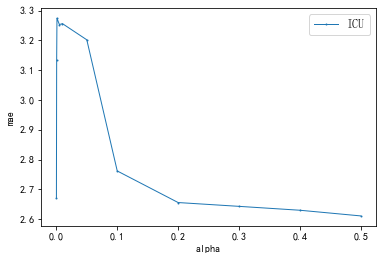

In [22]:
def lasso_exp():


    font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)

    # alphas = np.logspace(2, -10, 13)
    alphas = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 0.2, 0.3, 0.4, 0.5,
              ]
    print(alphas)
    coefs = np.zeros([13, 89])
    dict = []
    for alpha in alphas:
        cv_reg = linear_model.Lasso(alpha=alpha)
        scores = cross_validate(cv_reg, feature, label,
                                return_train_score=True,
                                cv=4,
                                return_estimator=True ,
                                scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
        i = 0
        weight = np.array([])
        test_mae = scores['test_neg_mean_absolute_error'].mean(axis=0)

        for est in scores['estimator']:
            if i == 0:
                weight = np.expand_dims([item for item in est.coef_], axis=0)
                # print([abs(item) for item in est.coef_])
                i+=1
            else:
                # print([abs(item) for item in est.coef_])
                weight = np.concatenate((weight, np.expand_dims([item for item in est.coef_], axis=0)), axis=0)
        weight = weight.mean(axis=0)
        dict.append([alpha, weight, test_mae])

    x = []
    y = []

    for i in range(len(alphas)):
        x.append(dict[i][0])
        y.append(abs(dict[i][2]))

    plt.plot(x, y,marker='o', linewidth=1, markersize=1, label= "ICU")
    plt.legend(prop=font_set)
    plt.xlabel("alpha")
    plt.ylabel("MAE")
    plt.savefig("./MAE.jpg", dpi=200)
    return dict
scores = lasso_exp()

In [6]:
def test():
    rates = np.array([])
    for i in range(100):
        sss = StratifiedShuffleSplit(n_splits=1, test_size=147,
                                 random_state=i)
        sps = sss.split(status, label>0)
        for sp in sps:
            train_ids, val_ids = sp

        train_positive_ids = np.array([])
        for id in train_ids:
            if label[id] != 0:
                train_positive_ids = np.append(train_positive_ids, id)

        print(len(train_positive_ids))

        train_negative_ids = np.setdiff1d(train_ids, train_positive_ids)
        np.random.shuffle(train_negative_ids)
        print(train_positive_ids.shape)
        print(train_negative_ids.shape)

        split_groups = np.array_split(train_negative_ids, 29)

        # print(split_groups[0].shape)

        for i in range(len(split_groups)):
            split_groups[i] = np.concatenate((split_groups[i], train_positive_ids)).astype(np.int)

        train_pred = []
        train_label = []

        for i in range(len(split_groups)):

            cls = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1, bootstrap=False)
            # cls = SVC(kernel='linear',C=10)
            # cls = SVC(kernel='rbf', gamma='auto', C=1000)
            # cls = SVC(kernel='poly', C=100000, gamma='auto', degree=2)

            cls.fit(feature[split_groups[i], :], label[split_groups[i]])

            train_pred = train_pred + cls.predict(feature[split_groups[i], :]).tolist()
            train_label = train_label + label[split_groups[i]].tolist()

            roc_pred = cls.predict(feature)

            pred = cls.predict(feature[val_ids, :])

            if i == 0:
                final_res = pred
                final_roc_pred = roc_pred
                # feature_ipt = np.expand_dims(cls.feature_importances_, axis=0)
            else:
                final_res = final_res + pred
                final_roc_pred = final_roc_pred + roc_pred
                # importance = cls.feature_importances_
                # feature_ipt = np.concatenate((feature_ipt, np.expand_dims(importance, axis=0)), axis=0)

        train_score, train_cm = evaluate(train_label, train_pred)

        print("-----train-----")
        print(train_score)
        print(train_cm)

        final_res = (final_res > (len(split_groups) // 2)).astype(float)
        score, cm = evaluate(label[val_ids], final_res)


        top = (final_res == 1) & (label[val_ids] == 0)
        extra_info_id = np.nonzero(top)
        raw_data = pd.read_csv("./数据v13_733.csv")
        extra_info_status = raw_data.loc[:, ['生死状态']].values.ravel()[val_ids]
        extra_info_status = extra_info_status[extra_info_id]
        num = np.sum(extra_info_status)

        num2_bool = (final_res == 1) & (label[val_ids] == 1)
        num2_id = np.nonzero(num2_bool)
        extra_info_status2 = raw_data.loc[:, ['生死状态']].values.ravel()[val_ids]
        extra_info_status2 = extra_info_status2[num2_id]
        num2 = np.sum(extra_info_status2)

        total = np.sum(raw_data.loc[:, ['生死状态']].values.ravel()[val_ids])


        rate = num/(total - num2 + 1e-6)

        rates = np.append(rates, rate)
        print("number is: " + str(num))
        print("total is: " + str(total))
        print("death rate is: " + str(rate))
    print(len(rates))
    print(rates)
    np.savetxt("./rate.txt", rates, fmt="%s")
    print(np.mean(rates))
    print(np.std(rates))

    return rates
rates = test()

20
(20,)
(566,)
-----train-----
[1. 1. 1. 1.]
[[566   0]
 [  0 580]]
number is: 2
total is: 4
death rate is: 0.6666664444445185
20
(20,)
(566,)
-----train-----
[1. 1. 1. 1.]
[[566   0]
 [  0 580]]
number is: 2
total is: 4
death rate is: 0.99999950000025
20
(20,)
(566,)
-----train-----
[1. 1. 1. 1.]
[[566   0]
 [  0 580]]
number is: 4
total is: 6
death rate is: 0.799999840000032
20
(20,)
(566,)
-----train-----
[1. 1. 1. 1.]
[[566   0]
 [  0 580]]
number is: 0
total is: 3
death rate is: 0.0
20
(20,)
(566,)
-----train-----
[1. 1. 1. 1.]
[[566   0]
 [  0 580]]
number is: 2
total is: 4
death rate is: 0.99999950000025
20
(20,)
(566,)
-----train-----
[1. 1. 1. 1.]
[[566   0]
 [  0 580]]
number is: 0
total is: 2
death rate is: 0.0
20
(20,)
(566,)
-----train-----
[1. 1. 1. 1.]
[[566   0]
 [  0 580]]
number is: 1
total is: 1
death rate is: 0.9999990000010001
20
(20,)
(566,)
-----train-----
[1. 1. 1. 1.]
[[566   0]
 [  0 580]]
number is: 2
total is: 4
death rate is: 0.99999950000025
20
(20,)
(566

In [ ]:
def percentile():

    path = "./数据V13_733.csv"
    csv = pd.read_csv(path)
    feature = csv.iloc[:, 1:92].values
    feature = feature[:, 0:68]
    column_names = csv.columns.tolist()[1:92]
    column_names = column_names[:, 0:68]
    label = csv.loc[:, ['是否ICU']].values.ravel()

    # percentile_table = pd.DataFrame(index=column_names,
    #                                 columns=['low', 'q1', 'mid', 'q3', 'high'])
    percentile_data = np.zeros([5, 68])
    for i in range(68):

        data = feature[:, i].ravel()
        ids = np.array([], dtype=int)
        for index, item in enumerate(data):
            # print(index, item)
            if not np.isnan(item):
                ids = np.append(ids, index)
        data = data[ids]
        midian = np.median(data)
        q3 = np.percentile(data, 0.75)
        q1 = np.percentile(data, 0.25)
        iqr = q3 - q1
        low = q1 - 1.5*iqr
        high = q3 + 1.5*iqr
        percentile_data[i, :] = [low, q1, midian, q3, high]

    percentile_table = pd.DataFrame(np.array(percentile_data),
                                    index=column_names,
                                    columns=['low', 'q1', 'mid', 'q3', 'high'])
    percentile_table.to_csv("./percentile_")

In [4]:
def ttest():

    path = "./数据v14_25_left.csv"
    data = pd.read_csv(path)

    row_names1 = ["超敏C反应蛋白_mean", "高敏肌钙蛋白I_mean",
                  "R_var", "白细胞数_mean", "肌红蛋白_mean",
                  "D-二聚体_mean", "超敏C反应蛋白_var",
                  "乳酸脱氢酶_mean", "R_mean", "白细胞数_var"]

    row_names2 = ["高敏肌钙蛋白I_mean", "肌红蛋白_mean",
                  "D-二聚体_mean", "高敏肌钙蛋白I_var",
                  "乳酸脱氢酶_mean", "肌红蛋白_var",
                  "免疫球蛋白IgM_mean", "肌酸激酶同工酶_mean",
                  "超敏C反应蛋白_mean", "年龄"]

    row_names3 = ["年龄"]

    row_names4 = ['性别', '高血压', '心脏病', '高血脂', '糖尿病',
                  '脑梗', '肝肾功能不全', '发热、干咳、乏力',
                  '咳嗽、浓痰', '双肺多发感染性病变', '是否出现拒食或喂养困难，有脱水症状']
    all_names = data.columns.tolist()

    for row_name in all_names:

        if row_name in ["就诊号码", '年龄']:
            continue
        sub_data = data[row_name]

        label = data['生死状态']

        # 去除空值
        ids = np.array([], dtype=int)
        for index, item in enumerate(sub_data):
            if not np.isnan(item):
                ids = np.append(ids, index)

        sub_data = sub_data[ids].values
        label = label[ids].values

        # 分成正负
        pos_ids = np.array([], dtype=int)
        neg_ids = np.array([], dtype=int)
        for index, item in enumerate(label):
            if item == 0:
                neg_ids = np.append(neg_ids, index)
            else:
                pos_ids = np.append(pos_ids, index)

        pos_sample = sub_data[pos_ids]
        neg_sample = sub_data[neg_ids]
        # (statistic, pvalue) = scipy.stats.mannwhitneyu(pos_sample, neg_sample)
        # s, p = scipy.stats.levene(pos_sample, neg_sample)
        # if p < 0.05:
        #     (statistic, pvalue) = scipy.stats.ttest_ind(pos_sample, neg_sample, equal_var=False)
        #
        # else:
        #     (statistic, pvalue) = scipy.stats.ttest_ind(pos_sample, neg_sample, equal_var=True)

        # print("result of " + row_name)
        # if row_name.split('_')[1] == "mean":
        #     (statistic, pvalue) = scipy.stats.ttest_ind(pos_sample, neg_sample)
        # elif row_name.split('_')[1] == "var":
        #     (statistic, pvalue) = scipy.stats.chisquare(pos_sample, neg_sample)
        # else:
        #     continue
        (statistic, pvalue) = scipy.stats.ttest_ind(pos_sample, neg_sample)
        print(row_name + " : " + str(pvalue))

    # print(sub_data)
    # print(label)


ttest()

磷酸肌酸激酶_mean : 0.14822741925197228
磷酸肌酸激酶_var : 0.35224611044055754
乳酸脱氢酶_mean : 0.0023243426276088252
乳酸脱氢酶_var : 0.17412641636661821
腺苷脱氨酶_mean : 0.011528490559720791
腺苷脱氨酶_var : 0.7106945677882646
总蛋白_mean : 0.18832797869792772
总蛋白_var : 0.44403488151620785
白蛋白_mean : 0.004510878663789853
白蛋白_var : 0.5777612361519961
谷丙转氨酶_mean : 0.0700531259193633
谷丙转氨酶_var : 0.1398169560741288
碱性磷酸酶_mean : 0.07716636483232917
碱性磷酸酶_var : 0.13920945803434268
血红蛋白浓度_mean : 0.532155285826988
血红蛋白浓度_var : 0.37263118786259586
红细胞数_mean : 0.2959875567712874
红细胞数_var : 0.3157832616311476
白细胞数_mean : 0.037786191311541546
白细胞数_var : 0.48872337601720905
淋巴细胞绝对值_mean : 0.0020765037591821307
淋巴细胞绝对值_var : 0.38414733216750074
淋巴细胞百分比_mean : 0.004628158594857949
淋巴细胞百分比_var : 0.08929126972996268
单核细胞绝对值_mean : 0.7820416173466176
单核细胞绝对值_var : 0.5016844006518308
单核细胞百分比_mean : 0.011877184566027892
单核细胞百分比_var : 0.38019140689934494
超敏C反应蛋白_mean : 0.3327036330333014
超敏C反应蛋白_var : 0.265383320264886
谷草转氨酶_mean : 0.01

In [41]:
def extra_exp():

    for i in range(10):
        sss = StratifiedShuffleSplit(n_splits=1, test_size=8,
                                 random_state=i)
        sps = sss.split(status, label>0)
        for sp in sps:
            train_ids, val_ids = sp

        train_positive_ids = np.array([])
        val_positive_ids = np.array([])

        for id in train_ids:
            if label[id] != 0:
                train_positive_ids = np.append(train_positive_ids, id)
        for id in val_ids:
            if label[id] != 0:
                val_positive_ids = np.append(val_positive_ids, id)

        train_negative_ids = np.setdiff1d(train_ids, train_positive_ids)
        val_negative_ids = np.setdiff1d(val_ids, val_positive_ids)

        # print(train_positive_ids.shape)
        # print(train_negative_ids.shape)
        # print(val_positive_ids.shape)
        # print(val_negative_ids.shape)

        cls = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=1, bootstrap=False)
        # cls = SVC(kernel='linear',C=10)
        # cls = SVC(kernel='rbf', gamma='auto', C=1000)
        # cls = SVC(kernel='poly', C=100, gamma='auto', degree=2)

        cls.fit(woblood[train_ids, :], label[train_ids])

        train_pred = cls.predict(woblood[train_ids]).tolist()
        train_label = label[train_ids]

        whole_pred = cls.predict(woblood).tolist()
        whole_label = label

        test_pred = cls.predict(woblood[val_ids, :])
        test_label = label[val_ids]

        train_score, train_cm = evaluate(train_label, train_pred)
        # print("-----train-----")
        # print(train_score)
        # print(train_cm)

        test_score, test_cm = evaluate(test_label, test_pred)
        # print("-----test-----")
        # print(test_score)
        # print(test_cm)

        whole_score, whole_cm = evaluate(whole_label, whole_pred)
        # print("-----whole-----")
        # print(whole_score)
        # print(whole_cm)

        if i == 0:
            final_train_score = np.expand_dims(train_score, axis=0)
            final_train_cm = np.expand_dims(train_cm, axis=0)
            final_test_score = np.expand_dims(test_score, axis=0)
            final_test_cm = np.expand_dims(test_cm, axis=0)
            final_whole_score = np.expand_dims(whole_score, axis=0)
            final_whole_cm = np.expand_dims(whole_cm, axis=0)
        else:
            final_train_score = np.concatenate((final_train_score, np.expand_dims(train_score, axis=0)), axis=0)
            final_train_cm = np.concatenate((final_train_cm, np.expand_dims(train_cm, axis=0)), axis=0)
            final_test_score = np.concatenate((final_test_score, np.expand_dims(test_score, axis=0)), axis=0)
            final_test_cm = np.concatenate((final_test_cm, np.expand_dims(test_cm, axis=0)), axis=0)
            final_whole_score = np.concatenate((final_whole_score, np.expand_dims(whole_score, axis=0)), axis=0)
            final_whole_cm = np.concatenate((final_whole_cm, np.expand_dims(whole_cm, axis=0)), axis=0)

    final_train_score = final_train_score.mean(axis=0)
    final_train_cm = final_train_cm.mean(axis=0)
    final_test_score = final_test_score.mean(axis=0)
    final_test_cm = final_test_cm.mean(axis=0)
    final_whole_score = final_whole_score.mean(axis=0)
    final_whole_cm = final_whole_cm.mean(axis=0)

    print("-----train-----")
    print(final_train_score)
    print(final_train_cm)

    print("-----test-----")
    print(final_test_score)
    print(final_test_cm)

    print("-----whole-----")
    print(final_whole_score)
    print(final_whole_cm)

extra_exp()


-----train-----
[0.96       1.         0.98823529 0.98      ]
[[12.   0. ]
 [ 0.2  4.8]]
-----test-----
[0.56666667 0.86       0.75       0.71333333]
[[4.3 0.7]
 [1.3 1.7]]
-----whole-----
[0.8125     0.95882353 0.912      0.88566176]
[[16.3  0.7]
 [ 1.5  6.5]]


In [336]:
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
import heapq

def feature_selection():
    path = "./数据v14_25_left.csv"

    csv = pd.read_csv(path)
    feature = csv.iloc[:, 1:76].values
    label = csv.loc[:, ['生死状态']].values.ravel()
    column_names = np.array(csv.columns.tolist()[1:76])
    filler = SimpleImputer(missing_values=np.nan, strategy="median")
    feature = filler.fit_transform(feature)

    feature[:, 0:52] = MinMaxScaler().fit_transform(feature[:, 0:52])
    temp = feature[:, 0:52]
    feature[:, 0:52] = temp[:, np.array(seq)]
    # return feature, temp

    temp2 = column_names
    column_names[0:52] = temp2[np.array(seq)]

    cls = SVC(kernel='linear')
    rfe = RFE(estimator=cls, step=1, n_features_to_select=10)
    rfe.fit(feature, label)
    # print("Optimal number of features : %d" % rfecv.n_features_)

    selected_ids = np.nonzero(rfe.support_.astype(int))
    print("selected features: ")
    print(column_names[selected_ids])

    pred = rfe.predict(feature)
    evaluate2(label, pred)

    # selected_ids = np.zeros(75, dtype=int)
    # grid_scores = np.zeros(20)
    # for i in range(20):
    #     # print(column_names[0:52])
    #     # cls = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=1,bootstrap=False)
    #     cls = SVC(kernel='linear')
    #     rfecv = RFECV(verbose=0, estimator=cls, step=1, cv=StratifiedKFold(3, shuffle=True, random_state=i), scoring='roc_auc', min_features_to_select=1)
    #     rfecv.fit(feature, label)
    #     # print("Optimal number of features : %d" % rfecv.n_features_)
    #
    #     selected_ids += rfecv.support_.astype(int)
    #     # print("selected features: ")
    #     # print(column_names[selected_ids])
    #     # print(rfecv.ranking_)
    #     # print(selected_ids)
    #     # print(rfecv.grid_scores_)
    #     grid_scores[i] = rfecv.grid_scores_.max()
    #
    # top_k_idx = selected_ids.argsort()[::-1][0:20]
    # print(column_names[top_k_idx])
    # print(grid_scores)
    # print(str(grid_scores.mean()) + " ± " + str(grid_scores.std()))
    # return rfecv.grid_scores_, feature
    for item in selected_ids[0]:
        print(final[item][3] + str(final[item][2]))

    return selected_ids

support = feature_selection()


selected features: 
['淋巴细胞百分比_mean' '淋巴细胞绝对值_mean' '乳酸脱氢酶_mean' 'D-二聚体_mean' '白蛋白_mean'
 '腺苷脱氨酶_mean' '乳酸脱氢酶_var' '直接胆红素_var' 'R_var' 'P_var']
淋巴细胞百分比_mean0.0294118168973401
淋巴细胞绝对值_mean0.03921573625527976
乳酸脱氢酶_mean0.892857024234716
D-二聚体_mean0.86764695815313
白蛋白_mean0.16806725181837223
腺苷脱氨酶_mean0.7773108264247048
乳酸脱氢酶_var0.23809526757369254
直接胆红素_var0.37815124306193515
R_var0.4227940987510855
P_var0.4816176173497029


In [315]:
def sort_roc():
    path = "./数据v14_25_left.csv"

    csv = pd.read_csv(path)
    feature = csv.iloc[:, 1:76].values
    label = csv.loc[:, ['生死状态']].values.ravel()
    column_names = np.array(csv.columns.tolist()[1:76])

    final = []
    for i in range(52):
        x = feature[:, i]
        y = label.ravel()
        ids = np.array([], dtype=int)
        for index, item in enumerate(x):
            if not np.isnan(item):
                ids = np.append(ids, index)
        print(column_names[i])
        print(len(ids))
        # if len(ids) == 0:
        #     continue
        x = x[ids]
        y = y[ids]
        info = np.array(sorted(zip(x, y), key=lambda sample: sample[0], reverse=False))

        x = info[:, 0]
        y = info[:, 1]

        tprs = [1]
        fprs = [1]

        for j in range(len(x)):
            threshold = x[j]
            true = y.astype(int)
            pred = (x >= threshold).astype(int)
            cm = confusion_matrix(true, pred, labels=[0, 1])
            TN, FP, FN, TP = cm.flatten()
            tpr = TP / (TP + FN + 1e-6)
            fpr = FP / (TN + FP + 1e-6)
            tprs.append(tpr)
            fprs.append(fpr)
        tprs.append(0)
        fprs.append(0)
        auc_score = auc(fprs, tprs)
        print(auc_score)
        # if auc_score < 0.5:
        #     auc_score = 1 - auc_score
        final.append([fprs, tprs, auc_score, column_names[i], i])
    final = sorted(final, key=lambda sample: abs(sample[2]-0.5), reverse=True)

    # for i in range(10):
    #     print(final[i][3], final[i][2])
    #     if final[i][2] < 0.5:
    #         plt.plot(final[i][1], final[i][0],
    #              marker='o', label=str(final[i][3]), linewidth=0.5, markersize=0.1
    #              )
    #     else:
    #         plt.plot(final[i][0], final[i][1],
    #                  marker='o', label=str(final[i][3]), linewidth=0.5, markersize=0.1
    #                  )
    #     plt.legend(prop=font_set)
    #     plt.xlabel("FPR")
    #     plt.ylabel("TPR")
    # # plt.plot(0.101671, 1.0, marker='o',
    # #          label="ROC10", linewidth=0.5, markersize=0.5)
    # # plt.legend(prop=font_set)
    # plt.savefig("./新任务.jpg", dpi=300)
    # plt.show()
    seq = []
    for i in range(52):
        seq.append(final[i][4])
    print(seq)
    return seq, final

seq, final = sort_roc()

年龄
22
0.5357142519132717
磷酸肌酸激酶_mean
19
0.7440475340844834
磷酸肌酸激酶_var
19
0.3214285820578228
乳酸脱氢酶_mean
19
0.892857024234716
乳酸脱氢酶_var
19
0.23809526757369254
腺苷脱氨酶_mean
24
0.7773108264247048
腺苷脱氨酶_var
24
0.4201680413106478
总蛋白_mean
24
0.37394956323706396
总蛋白_var
24
0.4033613220111627
白蛋白_mean
24
0.16806725181837223
白蛋白_var
24
0.4747898790339742
谷丙转氨酶_mean
24
0.6932772299272798
谷丙转氨酶_var
24
0.5126049974578155
碱性磷酸酶_mean
24
0.697478909752151
碱性磷酸酶_var
24
0.504201637808073
血红蛋白浓度_mean
23
0.43627447025183574
血红蛋白浓度_var
23
0.3039215589196505
红细胞数_mean
23
0.41666663153595646
红细胞数_var
23
0.3137254782775901
白细胞数_mean
23
0.8529410429642711
白细胞数_var
23
0.37254899442522804
淋巴细胞绝对值_mean
23
0.03921573625527976
淋巴细胞绝对值_var
23
0.27450980084583154
淋巴细胞百分比_mean
23
0.0294118168973401
淋巴细胞百分比_var
23
0.26470588148789187
单核细胞绝对值_mean
23
0.5882352202999004
单核细胞绝对值_var
23
0.3431372363514091
单核细胞百分比_mean
23
0.17647060726643493
单核细胞百分比_var
23
0.3137254782775901
超敏C反应蛋白_mean
23
0.6960783332372367
超敏C反应蛋白_var
23


In [77]:
def extra_roc():
    font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)

    for i in support[0]:
        # if i in [0,1,2,3,6,9,11,29,48]:
        #     continue
        # print(final[i][3], final[i][2])
        if final[i][2] < 0.5:
            plt.plot(final[i][1], final[i][0],
                 marker='o', label=str(final[i][3]), linewidth=0.5, markersize=0.1
                 )
        else:
            plt.plot(final[i][0], final[i][1],
                     marker='o', label=str(final[i][3]), linewidth=0.5, markersize=0.1
                     )
        plt.legend(prop=font_set)
        plt.xlabel("FPR")
        plt.ylabel("TPR")

    plt.savefig("./sel_roc.svg", dpi=300)
    plt.show()
extra_roc()

NameError: name 'support' is not defined

TPR:  0.875
FPR:  0.11764705882352941
SEN:  0.875
SPE:  0.8823529411764706
ACC:  0.88
AUC:  0.8786764705882353
0.9411764705882353


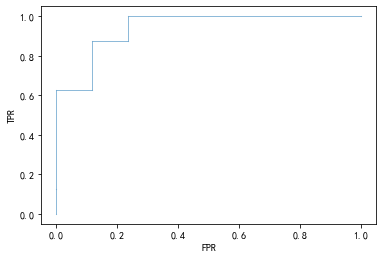

In [249]:
def loocv():
    from sklearn.model_selection import LeaveOneOut
    font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)
    loo = LeaveOneOut()
    final_pred = []
    final_true = []
    for train_index, test_index in loo.split(woblood):
        X_train, X_test = woblood[train_index], woblood[test_index]
        y_train, y_test = label[train_index], label[test_index]
        # print(test_index)
        cls = SVC(kernel='linear', probability=True)
        cls.fit(X_train, y_train)
        pred = cls.predict_proba(X_test)
        final_pred.append(pred)
        final_true.append(y_test)
        # evaluate2(y_test, pred)
        # print(y_test, pred)
    final_pred = np.array(final_pred).reshape([25,2])
    evaluate2(final_true, (final_pred[:,1]>0.5).astype(int))

    fpr, tpr, thresholds = roc_curve(final_true, final_pred[:, 1])
    AUC = auc(fpr, tpr)
    print(AUC)
    plt.plot(fpr, tpr, marker='o', label='AUC = %0.2f'%AUC, linewidth=0.5, markersize=0.1)
    plt.xlabel("FPR")
    plt.ylabel("TPR")

final_pred = loocv()

E:\Development\Anaconda\envs\Pytorch\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.6666666666666666 1.0 0.8888888888888888 1.0
0.6666666666666666 1.0 0.875 0.9333333333333333
1.0 0.8333333333333334 0.875 1.0
0.7777777777777777 0.9444444444444445 0.8796296296296297 0.9777777777777779


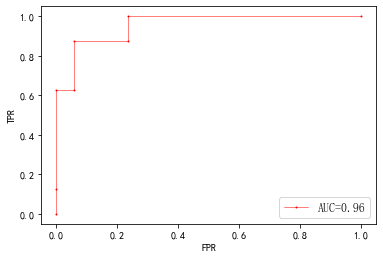

In [22]:
def cv():
    from sklearn.model_selection import StratifiedKFold
    from sklearn.externals import joblib
    i = 0
    num_split = 3
    font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)
    skf = StratifiedKFold(n_splits=num_split, random_state=1)
    FAUC = 0.
    FSEN = 0.
    FSPE = 0.
    FACC = 0.
    Ffpr = 0.
    Ftpr = 0.
    result = []
    all_true = []
    all_pred = []
    for train_index, test_index in skf.split(woblood, label):
        X_train, X_test = woblood[train_index], woblood[test_index]
        y_train, y_test = label[train_index], label[test_index]
        # print(test_index)
        cls = SVC(kernel='linear', probability=True)
        cls.fit(X_train, y_train)
        joblib.dump(cls, "./预测生死模型%s.pkl" % str(i))
        i += 1
        pred = cls.predict_proba(X_test)
        final_pred = pred
        all_pred.extend(pred[:, 1])
        final_true = y_test
        all_true.extend(final_true)
        # print(final_true)
        # print(final_pred[:, 1])
        fpr, tpr, thresholds = roc_curve(final_true, final_pred[:, 1])
        # print(fpr)
        AUC = roc_auc_score(final_true, final_pred[:, 1])

        SEN, SPE, ACC, AUC2 = evaluate2(final_true, (final_pred[:,1]>0.5).astype(int))
        print(SEN, SPE, ACC, AUC)
        result.append([fpr, tpr, thresholds, AUC])
        FAUC += AUC
        FSEN += SEN
        FSPE += SPE
        FACC += ACC

    FAUC /= num_split
    FSEN /= num_split
    FSPE /= num_split
    FACC /= num_split

    print(FSEN, FSPE, FACC, FAUC)

    afpr, atpr, athresholds = roc_curve(all_true, all_pred)
    aAUC = roc_auc_score(all_true, all_pred)
    result.append([afpr, atpr, athresholds, aAUC])
    # return result
    # print(result)
    # for i in range(3):
    #     plt.plot(result[i][0], result[i][1], marker='o', label='Fold %s AUC=%0.2f'%(str(i), result[i][3]), linewidth=0.5*(i+1), markersize=0.5*(i+1))
    # # plt.plot(fpr, tpr, marker='o', label='AUC = %0.2f'%AUC, linewidth=0.5, markersize=0.1)
    # plt.plot(result[0][0], result[0][1], marker='o', label='Fold %s AUC=%0.2f'%(str(0), result[0][3]), linewidth=0.5, markersize=5)
    # plt.plot(result[1][0], result[1][1], marker='*', label='Fold %s AUC=%0.2f'%(str(1), result[1][3]), linewidth=0.5, markersize=5)
    # plt.plot(result[2][0], result[2][1], marker='x', label='Fold %s AUC=%0.2f'%(str(2), result[2][3]), linewidth=0.5, markersize=5)
    plt.plot(result[3][0], result[3][1] ,marker='o', color='r', label='AUC=%.2f'%(result[3][3]), linewidth=0.5, markersize=1)
    plt.legend(prop=font_set, loc='lower right')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.savefig("./3fold.svg", dpi=300)

    return result
result = cv()

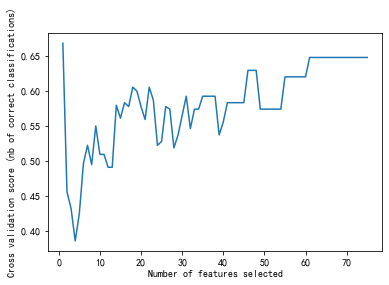

In [252]:
def feature_figure():
    from sklearn.svm import SVC
    from sklearn.model_selection import StratifiedKFold
    from sklearn.feature_selection import RFECV

    path = "./数据v14_25_left.csv"

    csv = pd.read_csv(path)
    feature = csv.iloc[:, 1:76].values
    label = csv.loc[:, ['生死状态']].values.ravel()
    column_names = np.array(csv.columns.tolist()[1:76])
    filler = SimpleImputer(missing_values=np.nan, strategy="median")
    feature = filler.fit_transform(feature)

    feature[:, 0:52] = MinMaxScaler().fit_transform(feature[:, 0:52])
    temp = feature[:, 0:52]
    feature[:, 0:52] = temp[:, np.array(seq)]
    # return feature, temp

    temp2 = column_names
    column_names[0:52] = temp2[np.array(seq)]


    cls = SVC(kernel="linear")
    rfecv = RFECV(estimator=cls, step=1, cv=StratifiedKFold(3),
              scoring='roc_auc')

    rfecv.fit(feature, label)
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.savefig("./特征数.jpg", dpi=300)
    plt.show()
feature_figure()

In [11]:
def correlation():

    path = "./数据v14_14.csv"
    csv = pd.read_csv(path)
    feature = csv.iloc[:, 1:92].values
    label = csv.loc[:, ['ICU']].values.ravel()
    columns = np.array(csv.columns.tolist()[1:92])

    with open("./新ICU回归.txt", 'r', encoding='utf-8') as f_newicu:
        newicu_name = f_newicu.readlines()
    for i in range(len(newicu_name)):
        newicu_name[i] = newicu_name[i].strip()

    newicu = csv.loc[:, newicu_name].values

    filler = SimpleImputer(missing_values=np.nan, strategy="median")
    newicu = filler.fit_transform(newicu)
    feature = filler.fit_transform(feature)

    for i in range(10):

        subdata = newicu[:, i]
        # print(subdata)
        # print(label)
        statistic, pvalue = scipy.stats.ttest_ind(subdata, label)
        # s, p = scipy.stats.levene(subdata, label)
        # if p < 0.05:
        #     (statistic, pvalue) = scipy.stats.ttest_ind(subdata, label, equal_var=False)
        #
        # else:
        #     (statistic, pvalue) = scipy.stats.ttest_ind(subdata, label, equal_var=True)
        print(newicu_name[i], statistic, pvalue)


correlation()


年龄 18.826468130387294 1.1363535641905199e-16
红细胞数_mean 0.9812835006555064 0.33549647918204306
淋巴细胞绝对值_mean -4.28250921489236 0.00022307081987208934
高敏肌钙蛋白I_var 14.418619376143884 6.475743328921482e-14
超敏C反应蛋白_mean 3.825555281972873 0.0007356340576214526
总胆固醇_mean 1.316991011629546 0.1993318589750818
总胆固醇_var -5.608089739715624 6.805857882019359e-06
腺病毒IgM抗体 -5.911205116087014 3.0964307862076334e-06
Q热立克次体IgM抗体 -6.10227179185023 1.8922196359426327e-06
心脏病 -6.506311248452532 6.756208236393615e-07
